In [1]:
# Ипортируем библиотеки
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

d:\python\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Загружаем датасеты
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,PATIENT_SEX,MKB_CODE,ADRES,AGE_CATEGORY,PATIENT_ID_COUNT,MONTH,YEAR,SEASON,MKB_GROUP,ZONE
0,0,A00.0,Гурьевск,young,1,8,21,3,0,0
1,0,A00.0,Калининград,children,1,3,2,2,0,0
2,0,A00.0,Гусев,children,1,3,19,2,0,1
3,0,A00.0,Калининград,children,1,1,22,1,0,0
4,0,A00.0,Калининград,children,1,2,18,1,0,0


In [3]:
# Города, кол-во больных в которых надо предсказать
target_address = df_test['ADRES'].unique()
target_address

array(['Калининград', 'Гурьевск', 'Черняховск', 'Балтийск',
       'Багратионовск', 'Пионерский', 'Гвардейск', 'Зеленоградск',
       'Нестеров', 'Правдинск', 'Славск', 'Советск', 'Полесск', 'Светлый',
       'Гусев', 'Озерск', 'Краснознаменск', 'Мамоново', 'Неман',
       'Светлогорск'], dtype=object)

In [4]:
# Города, не вошедшие в список выше
other = df_train['ADRES'][~df_train['ADRES'].isin(target_address)].unique()
other

array(['Партизанское', 'Садовое', 'Ясная Поляна', 'Холмогоровка',
       'Большое Исаково', 'Калининградская', 'Колосовка', 'Невское',
       'Прибрежный', 'СТ Железнодорожник', 'СТ Искра ул. Тюльпановая',
       'СТ Победа', 'Совхозное', 'Малое Васильково', 'Сосновка',
       'Ладушкин', 'Малинники', 'Раздольное', 'Волочаевское', 'Нивенское',
       'Васильково', 'Голубево', 'Долгоруково', 'Донское', 'Дружный',
       'Заозерье', 'Корнево', 'Ласкино', 'Луговое', 'Люблино',
       'Малиновка', 'Малое Исаково', 'Матросово', 'Озерки',
       'Переславское', 'Пятидорожное', 'СТ Колосок', 'СТ Радуга',
       'Саранское', 'Славинск', 'Славянское', 'Ушаково', 'Янтарный',
       'Ясное', 'Илюшино', 'Шоссейное', 'Южный', 'Петрово', 'Некрасово',
       'Березовка', 'Большаково', 'Высокое', 'Домново', 'Дорожный',
       'Железнодорожный', 'Знаменск', 'Коврово', 'Комсомольск',
       'Константиновка', 'Крылово', 'Кумачево', 'Майское', 'Мельниково',
       'Муромское', 'Низовье', 'Новодорожный', '

In [5]:
# Удаление городов, которых нет в TEST датасете + удаление 2002 года
df_train = df_train[df_train['ADRES'].isin(target_address)]
df_train = df_train[df_train['YEAR'] != 2].reset_index(drop=True)

In [6]:
# Преобразование данных:
# Удаление некоторых столбцов
# Кодирование строк в числа
enc_age = LabelEncoder().fit(df_train['AGE_CATEGORY'])
enc_adres = LabelEncoder().fit(df_train['ADRES'])

for df in [df_train, df_test]:
    df['MONTH'] -= 1
    df.drop(['SEASON', 'MKB_GROUP', 'ZONE'], axis=1, inplace=True)
    df['AGE_CATEGORY'] = enc_age.transform(df['AGE_CATEGORY'])
    df['ADRES'] = enc_adres.transform(df['ADRES'])

In [7]:
# Составление X и Y для модели
x, y = df_train.drop('PATIENT_ID_COUNT', axis=1), df_train['PATIENT_ID_COUNT']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [8]:
x.columns

Index(['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY', 'MONTH', 'YEAR'], dtype='object')

In [9]:
# Модель разделения
# Она разделяет датасет на группы по
# установленному правилу и для каждой группы обучает указанную
# модель. Это может использовано, например, в качестве обхода
# добавления новых признаков.
class SeparationModel:
    # Конструктор
    def __init__(self, estimator='catboost', cat_features=None, by=['ADRES'], models=None, min_samples=0):
        if type(by) == str:
            by = [by]
        if estimator == 'catboost' and cat_features is None:
            raise Exception('You must provide list of'
            'cat features in order to user catboost')
        self.cat_features = cat_features
        self.by = by
        self.estimator = estimator
        if models is not None:
            self.models = models
        self.min_samples = min_samples
    
    # Метод для создания "имени" для каждой группы
    def _create_label(self, values):
        if type(values) not in [list, tuple]:
            return str(values)
        return '&'.join([
            str(v) for v in values
        ])

    # Метод обучения
    def fit(self, x, y):
        x = x.copy()
        x['PATIENT_ID_COUNT'] = y
        self.models = {}
        x = x.groupby(self.by)
        passed = 0
        # Проход по всем группам
        for group in tqdm(x.groups.keys()):
            label = self._create_label(group)
            sub_df = x.get_group(group)
            # При недостаточном кол-ве строк в группе
            # модель не обучается.
            if len(sub_df) < self.min_samples:
                passed += 1
                continue
            # Разделение данных и обучение
            x_train_local, y_train_local = sub_df.drop(
                ['PATIENT_ID_COUNT'] + self.by, axis=1), sub_df['PATIENT_ID_COUNT']
            if self.estimator == 'catboost':
                train_data = Pool(x_train_local, y_train_local, cat_features=self.cat_features)
                self.models[label] = CatBoostRegressor().fit(train_data, verbose=0)
            elif self.estimator == 'randomforest':
                self.models[label] = RandomForestRegressor().fit(x_train_local, y_train_local)
            else:
                raise Exception(f'Unknown estimator: {self.estimator}')
        passed_perc = round(passed / len(x.groups.keys()) * 100, 2)
        print(f'Done, passed {passed_perc}% of all groups.')
        return self

    # Метод предсказания
    # Предсказанные значение могут содержать NaN
    def predict(self, x):
        x.reset_index(drop=True, inplace=True)
        x = x.groupby(self.by)
        output = []
        for group in tqdm(x.groups.keys()):
            label = self._create_label(group)
            df = x.get_group(group).drop(self.by, axis=1)
            if label not in self.models:
                pred = [np.nan] * len(df)
            else:
                pred = self.models[label].predict(df)
            output += list(zip(df.index, pred))
        output = sorted(output, key=lambda x: x[0])
        return np.round(np.abs(np.array(output)[:, 1]))

    # Оценка модели
    def score(self, x, y):
        y_hat = self.predict(x)
        return r2_score(y, y_hat)

In [10]:
# Обучение модели
model = SeparationModel(
    estimator='randomforest',
    by=['MKB_CODE', 'YEAR'],
    min_samples=50).fit(x, y)

100%|██████████| 22565/22565 [08:01<00:00, 46.85it/s] 

Done, passed 75.63% of all groups.


100%|██████████| 4048/4048 [00:04<00:00, 847.29it/s] 


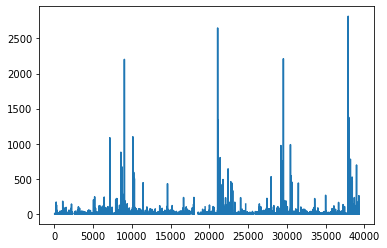

In [11]:
# Предсказание данных на TEST датасете
pred = model.predict(df_test)
plt.plot(pred)

In [14]:
# Чтение предсказаний из 1-ой модели
subm = pd.read_csv('submission1.csv', sep=';', dtype={'VISIT_MONTH_YEAR': str})

In [15]:
# Подсчёт предсказанной части
actually_pred = np.where(1 - np.isnan(pred))[0]
len(actually_pred) / len(pred)

0.5109338887054581

In [16]:
# Замена некоторых значений из старых предсказаний на предсказания модели
subm.loc[actually_pred, 'PATIENT_ID_COUNT'] = np.round(
    (subm['PATIENT_ID_COUNT'][actually_pred] + pred[actually_pred]) / 2)

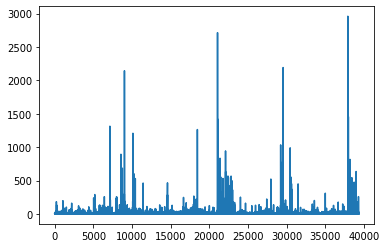

In [17]:
# График
plt.plot(subm['PATIENT_ID_COUNT'])

In [18]:
# Сохранение
subm.to_csv('submission2.csv', index=False, sep=';')